In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context='notebook')
figure_folder = 'figures/fBm/'

import numpy as np

from joblib import Parallel, delayed
import pandas as pd

from pymultifracs.simul.noisy import create_mask3, gen_estimate, \
    generate_simuls, generate_simuls_bb, gen_noisy, estimate

from pymultifracs.mfa import mf_analysis
from pymultifracs.wavelet import wavelet_analysis
from pymultifracs.robust import reject_coefs
from pymultifracs.wavelet import compute_leaders2
from pymultifracs.viz import plot_coef

In [3]:
def iterate_analysis(WT, n_iter=10, verbose=False):

    lwt = mf_analysis([WT.wt_leaders], scaling_ranges=[(6, WT.wt_leaders.j2_eff() - 2)], n_cumul=4)[0]

    c_trace = np.zeros((4, 1, WT.wt_coefs.values[1].shape[1], n_iter+1))

    c_trace[:, :, :, 0] = lwt.cumulants.log_cumulants

    new_leaders = WT.wt_leaders

    for i in range(n_iter):

        idx_reject = reject_coefs(WT.wt_coefs, lwt.cumulants, 2, 1000000,
                                  verbose=False)
        
        if verbose:
            idx_reject_pos = {
                scale: np.arange(WT.wt_leaders.values[scale].shape[0])[idx_reject[scale][0, 0]]
                for scale in idx_reject
            }
            plt.figure()
            plot_coef(new_leaders.values, 4, 12, leader=True, nan_idx=idx_reject_pos, vmin=0)
            plt.show()

        new_leaders, _ = compute_leaders2(WT.wt_coefs, gamint=1, p_exp=2, j1=6,
                                          j2_reg=12, idx_reject=idx_reject)
        lwt = mf_analysis([new_leaders],
                          scaling_ranges=[(6, WT.wt_leaders.j2_eff() - 2)],
                          n_cumul=4)[0]

        if verbose:
            lwt.cumulants.plot(nrow=4)
            plt.show()
        
        c_trace[:, :, :, i+1] = lwt.cumulants.log_cumulants

    return c_trace, new_leaders, idx_reject, lwt

In [4]:
def estimate(gen_func, robust_cm=False, bootstrap_weight=False,
             robust_iter=False, **gen_func_kwargs):

    noisy_X = gen_func(**gen_func_kwargs)

    WT = wavelet_analysis(noisy_X.reshape(noisy_X.shape[0], -1), p_exp=2, j1=8,
                          j2_reg=14, gamint=1)

    R = 1
    weighted = None

    if bootstrap_weight:
        R = 25
        weighted = 'bootstrap'

    dwt, lwt = mf_analysis([WT.wt_coefs, WT.wt_leaders],
                           scaling_ranges=[(8, WT.wt_leaders.j2_eff()-2)],
                           robust=robust_cm, R=R, weighted=weighted, n_cumul=4)
    
    if robust_iter:
        _, _, _, lwt = iterate_analysis(WT)


    return lwt.cumulants

In [5]:
def gen_estimate(N, gen_func, SNRgrid, covgrid, align_scale, n_jobs=10,
                 n_rep=1, robust_cm=False, bootstrap_weight=False,
                 robust_iter=False):

    df_list = []

    for rep in range(n_rep):

        signal, noise = gen_func(N=N)

        covlist = np.array_split(covgrid, n_jobs)

        cms = Parallel(n_jobs=n_jobs)(
            delayed(estimate)(gen_noisy, signal=signal, noise=noise,
                              coverage=cov, SNR=SNRgrid,
                              align_scale=align_scale, robust_cm=robust_cm,
                              bootstrap_weight=bootstrap_weight,
                              robust_iter=robust_iter)
            for cov in covlist)

        c1_dfs = [
            pd.DataFrame(cms[i].c1.squeeze().reshape(-1, SNRgrid.shape[0]),
                         index=cov, columns=SNRgrid)
            for i, cov in enumerate(covlist)]
        c2_dfs = [
            pd.DataFrame(cms[i].c2.squeeze().reshape(-1, SNRgrid.shape[0]),
                         index=cov, columns=SNRgrid)
            for i, cov in enumerate(covlist)]
        c3_dfs = [
            pd.DataFrame(cms[i].c3.squeeze().reshape(-1, SNRgrid.shape[0]),
                         index=cov, columns=SNRgrid)
            for i, cov in enumerate(covlist)]

        c1_df = pd.concat(c1_dfs).rename_axis(
            columns='SNR', index=['coverage'])
        c2_df = pd.concat(c2_dfs).rename_axis(
            columns='SNR', index=['coverage'])
        c3_df = pd.concat(c3_dfs).rename_axis(
            columns='SNR', index=['coverage'])

        df = pd.concat([c1_df, c2_df, c3_df], keys=['c1', 'c2', 'c3'], axis=1,
                        names=['cumulant', 'SNR'])

        df_list.append(df)

    return pd.concat(df_list, axis=0, keys=np.arange(n_rep),
                     names=['rep', 'coverage'])


#### Broadband noise

In [ ]:
N = int(1.5 * 2 ** 17)

In [8]:
SNRgrid = np.r_[0, np.geomspace(1, 8, 5)[1:]]
covgrid = np.arange(7)

df_bb = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40,
                     n_jobs=7, align_scale=12)

In [9]:
df_cm = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40,
                     n_jobs=7, align_scale=12, robust_cm=True)

In [ ]:
df_iter = gen_estimate(N, generate_simuls_bb, SNRgrid, covgrid, n_rep=40,
                       n_jobs=7, align_scale=12, robust_iter=True)

/u/74/dumeurm1/unix/PhD/pymultifracs/pymultifracs/robust.py:191: RuntimeWarning: invalid value encountered in sqrt
  alpha[i] = np.sqrt(C2 * gamma(1/beta[i]) / gamma(3/beta[i]))
/u/74/dumeurm1/unix/PhD/pymultifracs/pymultifracs/robust.py:191: RuntimeWarning: invalid value encountered in sqrt
  alpha[i] = np.sqrt(C2 * gamma(1/beta[i]) / gamma(3/beta[i]))
/u/74/dumeurm1/unix/PhD/pymultifracs/pymultifracs/robust.py:191: RuntimeWarning: invalid value encountered in sqrt
  alpha[i] = np.sqrt(C2 * gamma(1/beta[i]) / gamma(3/beta[i]))
/u/74/dumeurm1/unix/PhD/pymultifracs/pymultifracs/robust.py:191: RuntimeWarning: invalid value encountered in sqrt
  alpha[i] = np.sqrt(C2 * gamma(1/beta[i]) / gamma(3/beta[i]))
/u/74/dumeurm1/unix/PhD/pymultifracs/pymultifracs/robust.py:191: RuntimeWarning: invalid value encountered in sqrt
  alpha[i] = np.sqrt(C2 * gamma(1/beta[i]) / gamma(3/beta[i]))


In [ ]:
df_iter.to_pickle('../data/df_iter.pkl')

In [10]:
df_iter = pd.read_pickle('../data/df_iter.pkl')

In [11]:
delta = np.diff(np.log(SNRgrid[1:]))[0]
SNRgrid_plot = SNRgrid.copy()
SNRgrid_plot[0] = np.e ** (np.log(SNRgrid[1]) - delta)

In [12]:
def get_plot_dfs(df):

    df_consistency = df.copy()

    for rep in df.index.get_level_values(level=0):
        for c in 'c1 c2 c3'.split(' '):
            df_consistency.loc[rep, c] = (df_consistency.loc[rep, c] - df_consistency.loc[(rep, 0), (c, 0)]).values

    df_theoretical = df.copy()
    df_theoretical.c1 -= .8

    return df_consistency, df_theoretical

In [13]:
df_cm_cons, df_cm_th = get_plot_dfs(df_cm)
df_bb_cons, df_bb_th = get_plot_dfs(df_bb)
df_iter_cons, df_iter_th = get_plot_dfs(df_iter)

In [14]:
def compute_stat(df, stat):

    if stat == 'bias':
        df_plot = df.groupby('coverage').mean()
    elif stat == 'var':
        df_plot = df.groupby('coverage').var()
    elif stat == 'mse':
        df_plot = df.groupby('coverage').mean() ** 2 + df.groupby('coverage').var()

    return df_plot

In [15]:
def plot_map(covgrid, SNRgrid, df, var, stat, linthresh=None, ax=None,
             cbar=True, cbar_label=None, vmax=None):

    if stat in ['var', 'mse'] and len(df.index.get_level_values(0).unique()) == 1:
        return

    df_plot = compute_stat(df, stat)

    if ax is None:
        _, ax = plt.subplots()

    if vmax is None:
        vmax = np.abs(df_plot.loc[:, var].values).max()

    if stat == 'bias':
        cmap = 'icefire'
        vmin = -vmax

    elif stat in ['var', 'mse']:
        cmap = 'inferno'
        vmin = 0

    if linthresh is None:
        linthresh = np.quantile(np.abs(df_plot.loc[:, var].values.flatten()), .75)
    norm = colors.SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)

    gm = ax.pcolormesh(covgrid, SNRgrid_plot, df_plot.loc[:, var].transpose(), shading='auto', norm=norm, cmap=cmap)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(ticker.LogLocator(base=2, numticks=30))
    ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation(base=2, labelOnlyBase=False))
    ax.set_ylim(np.e ** (np.log(SNRgrid[1]) - 3 * delta / 2), np.e ** (np.log(SNRgrid[-1]) + delta / 2))
    if cbar:
        plt.colorbar(gm, label=cbar_label.format(var=var, stat=stat) if cbar_label is not None else cbar_label, ax=ax)
    else:
        return gm

In [16]:
def plot_all(df):

    _, ax = plt.subplots(3, 3, figsize=(10, 9), sharex=True, sharey=True)

    for i, var in enumerate('c1 c2 c3'.split(' ')):
        for j, stat in enumerate('bias var mse'.split(' ')):

            cbar_label = None

            if j == 2:
                cbar_label = '{var} statistic'

            plot_map(covgrid, SNRgrid_plot, df, var, stat, ax=ax[i, j],
                    cbar_label=cbar_label)

    ax[0, 0].set(title='Bias', ylabel='1/SNR')
    ax[1, 0].set(ylabel='1/SNR')
    ax[2, 0].set(ylabel='1/SNR', xlabel='Pulse count')
    ax[0, 1].set(title='Variance')
    ax[0, 2].set(title='MSE')
    ax[2, 1].set(xlabel='Pulse count')
    ax[2, 2].set(xlabel='Pulse count')

    plt.tight_layout()

    plt.show()

In [17]:
def extract_vmax(df_list, stat, var):

    df_stat_list = [
        compute_stat(df, stat) for df in df_list
    ]

    vmax = max([
        np.abs(df.loc[:, var].values).max()
        for df in df_stat_list
    ])

    linthresh = max([
        np.quantile(np.abs(df.loc[:, var].values.flatten()), .75)
        for df in df_stat_list
    ])

    return vmax, linthresh

In [18]:
def plot_compare(df_list, stat, var, cbar_ratio=.1):

    n_plots = len(df_list)
    _, ax = plt.subplots(1, n_plots + 1,
                         width_ratios=[1-cbar_ratio / n_plots] * n_plots + [cbar_ratio],
                         figsize=(1/(1-cbar_ratio) * n_plots * 3, 3))

    vmax, linthresh = extract_vmax(df_list, stat, var)

    for i, df in enumerate(df_list):

        gm = plot_map(covgrid, SNRgrid_plot, df, var, stat, linthresh, 
                      ax=ax[i], vmax=vmax, cbar=False)
        
    plt.colorbar(gm, label='', cax=ax[-1])
    plt.show()

#### Internal consistency

In [20]:
list_df = [df_bb_cons, df_cm_cons, df_iter_cons]

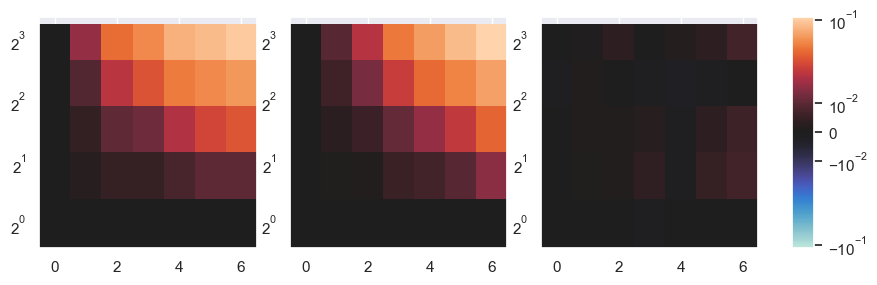

In [23]:
plot_compare(list_df, 'bias', 'c1', cbar_ratio=.1)

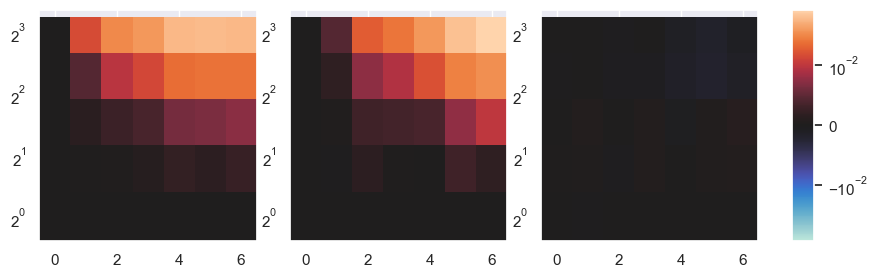

In [24]:
plot_compare(list_df, 'bias', 'c2', cbar_ratio=.1)

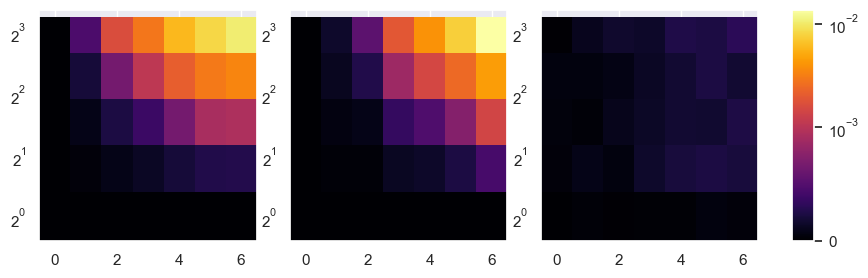

In [25]:
plot_compare(list_df, 'mse', 'c1', cbar_ratio=.1)

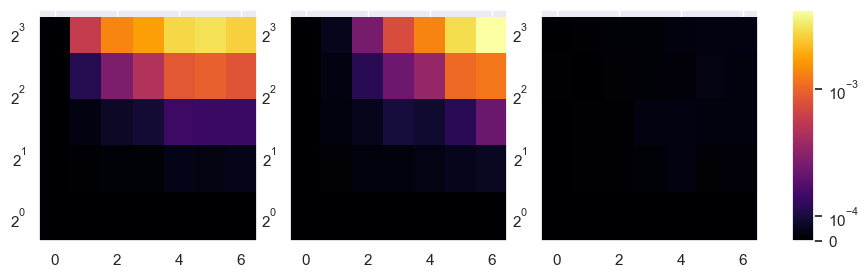

In [26]:
plot_compare(list_df, 'mse', 'c2', cbar_ratio=.1)

#### Compared w/ theoretical value

In [19]:
list_df = [df_bb_th, df_cm_th, df_iter_th]

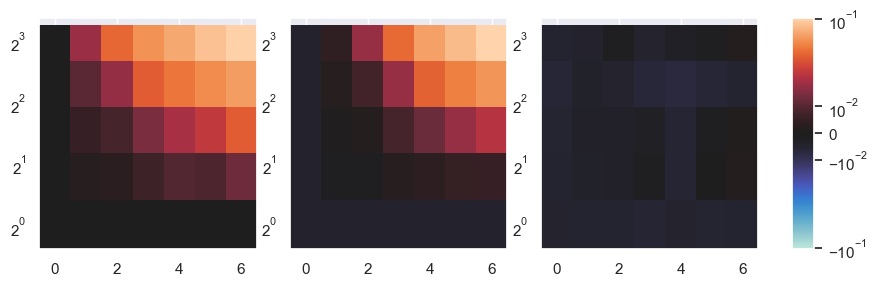

In [20]:
plot_compare(list_df, 'bias', 'c1', cbar_ratio=.1)

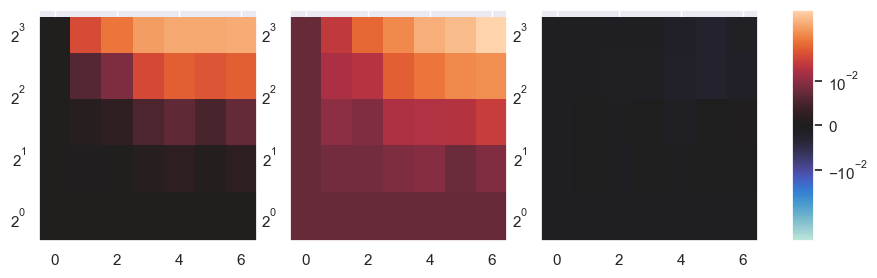

In [21]:
plot_compare(list_df, 'bias', 'c2', cbar_ratio=.1)

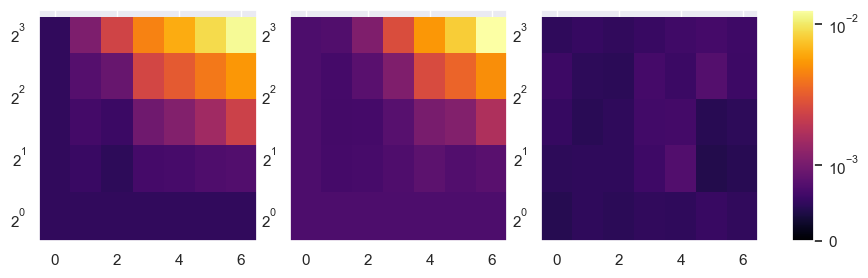

In [22]:
plot_compare(list_df, 'mse', 'c1', cbar_ratio=.1)

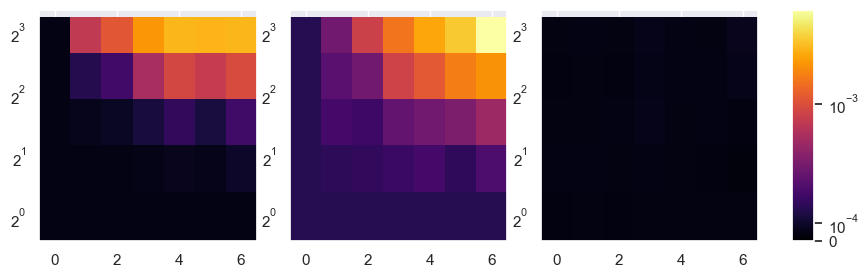

In [23]:
plot_compare(list_df, 'mse', 'c2', cbar_ratio=.1)

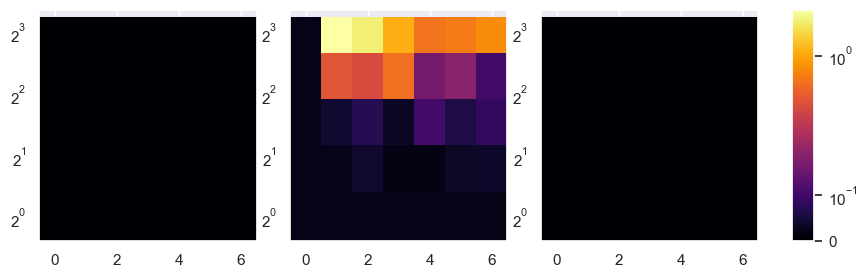

In [24]:
plot_compare(list_df, 'mse', 'c3', cbar_ratio=.1)

KeyError: 'c4'

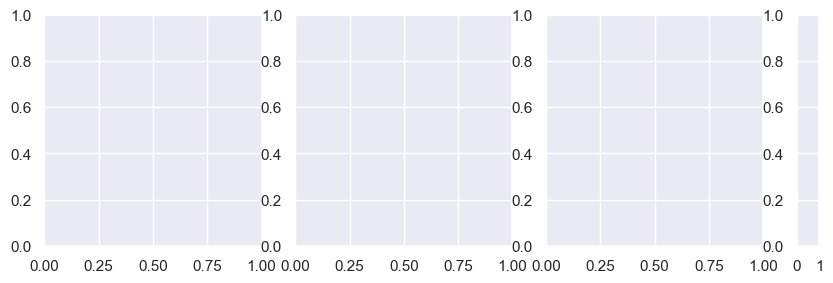

In [25]:
plot_compare(list_df, 'mse', 'c4', cbar_ratio=.1)

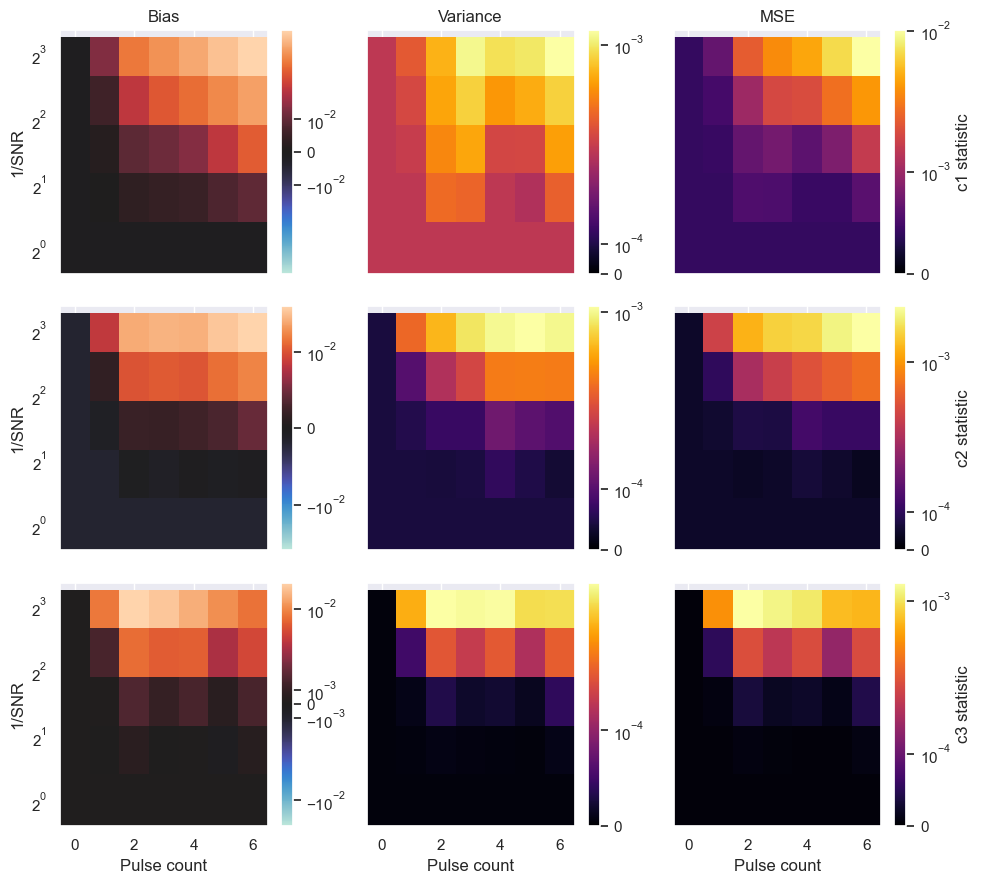

In [111]:
plot_all(df_bb_th)

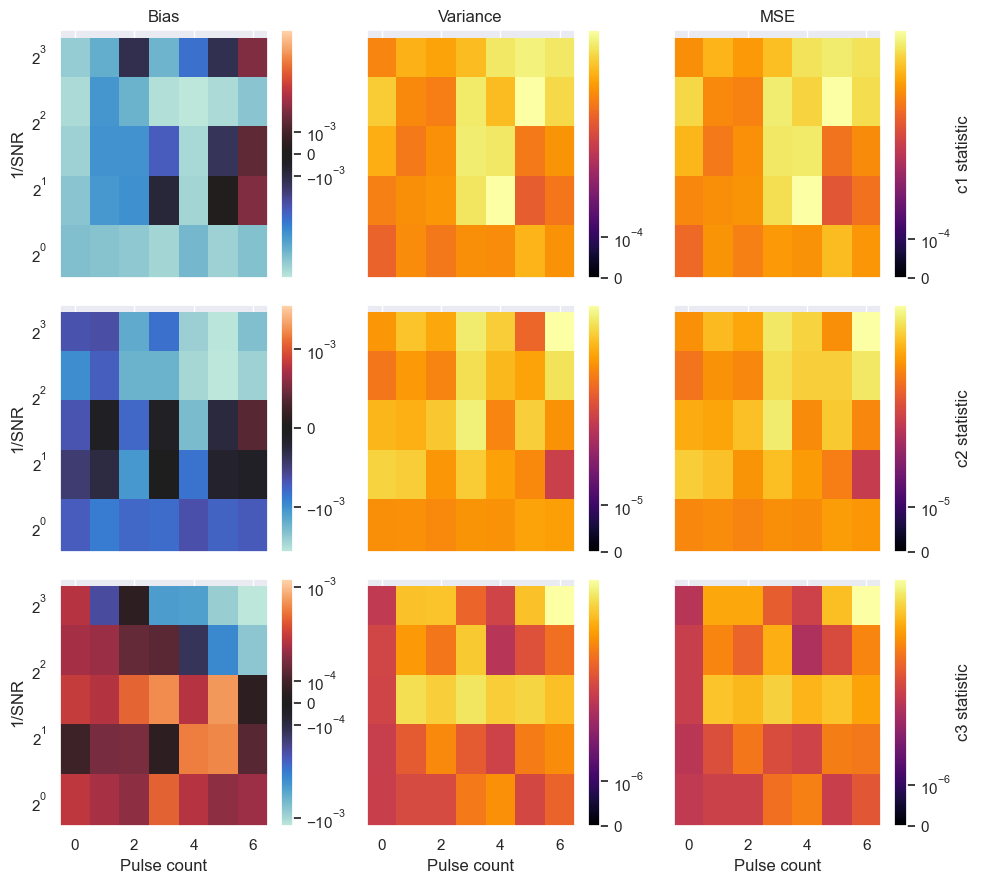

In [117]:
plot_all(df_iter_th)

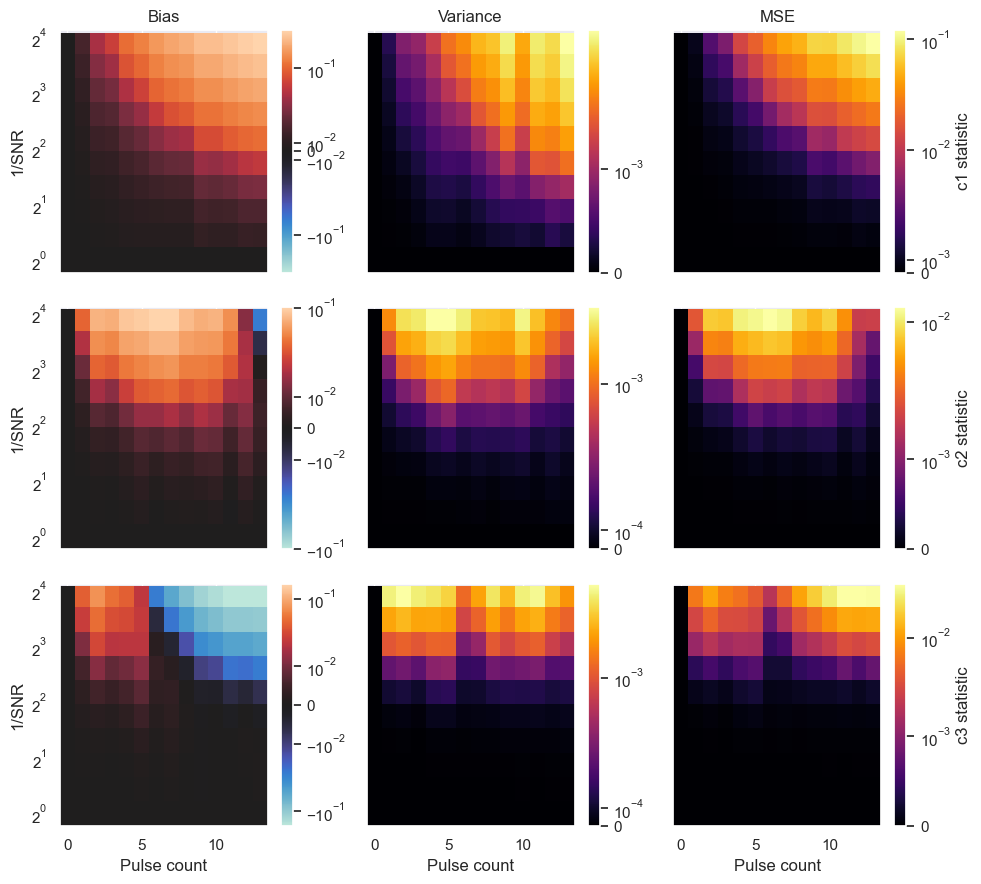

In [34]:
plot_all(df_bb_cons)

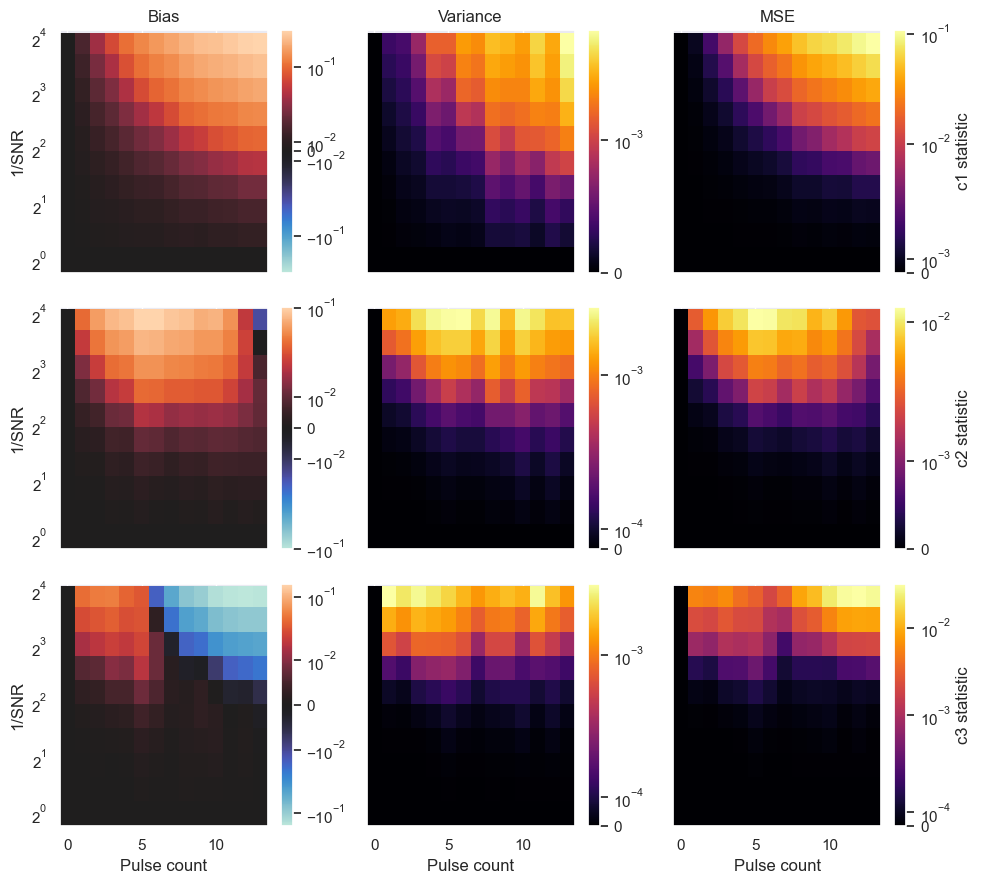

In [36]:
plot_all(df_cm_cons)

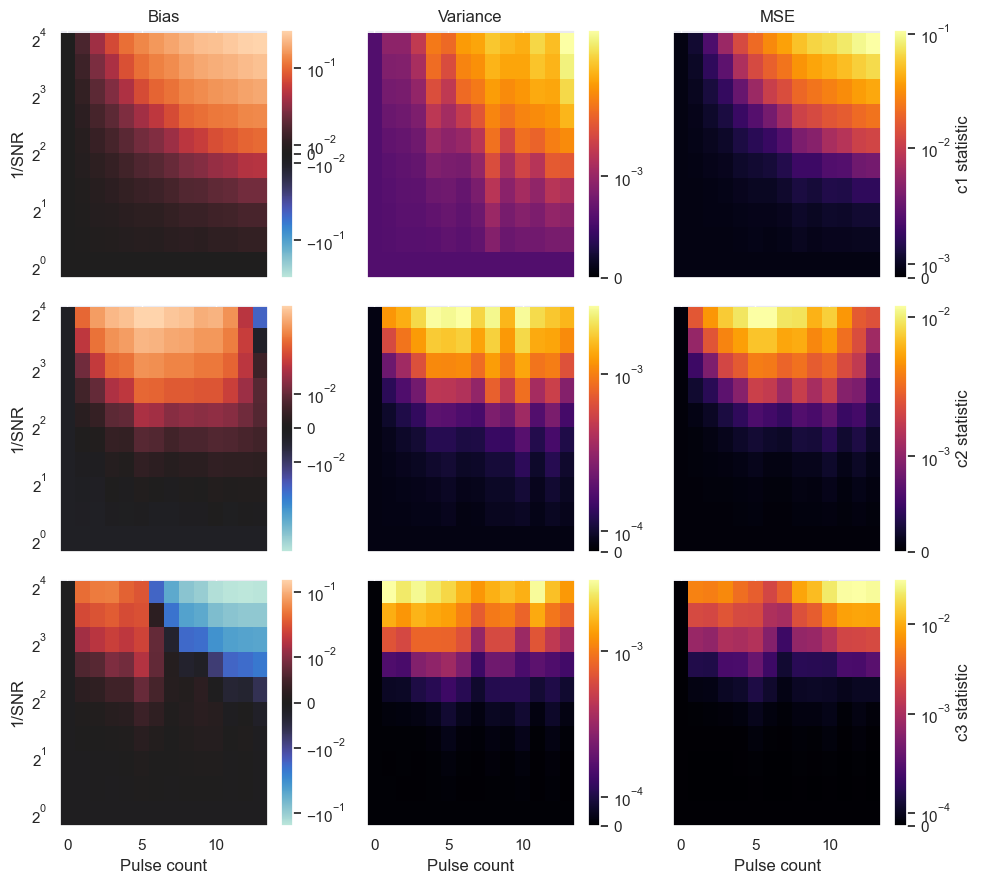

In [37]:
plot_all(df_cm_th)

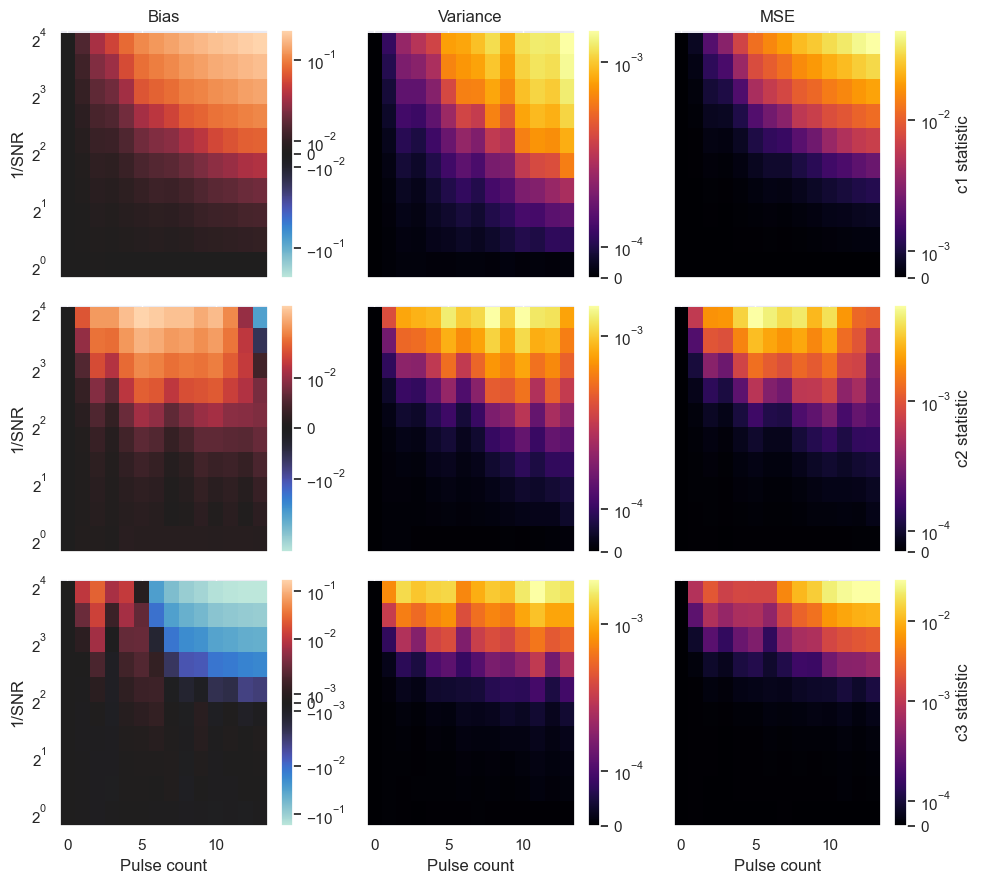

In [39]:
plot_all(df_boot_cons)

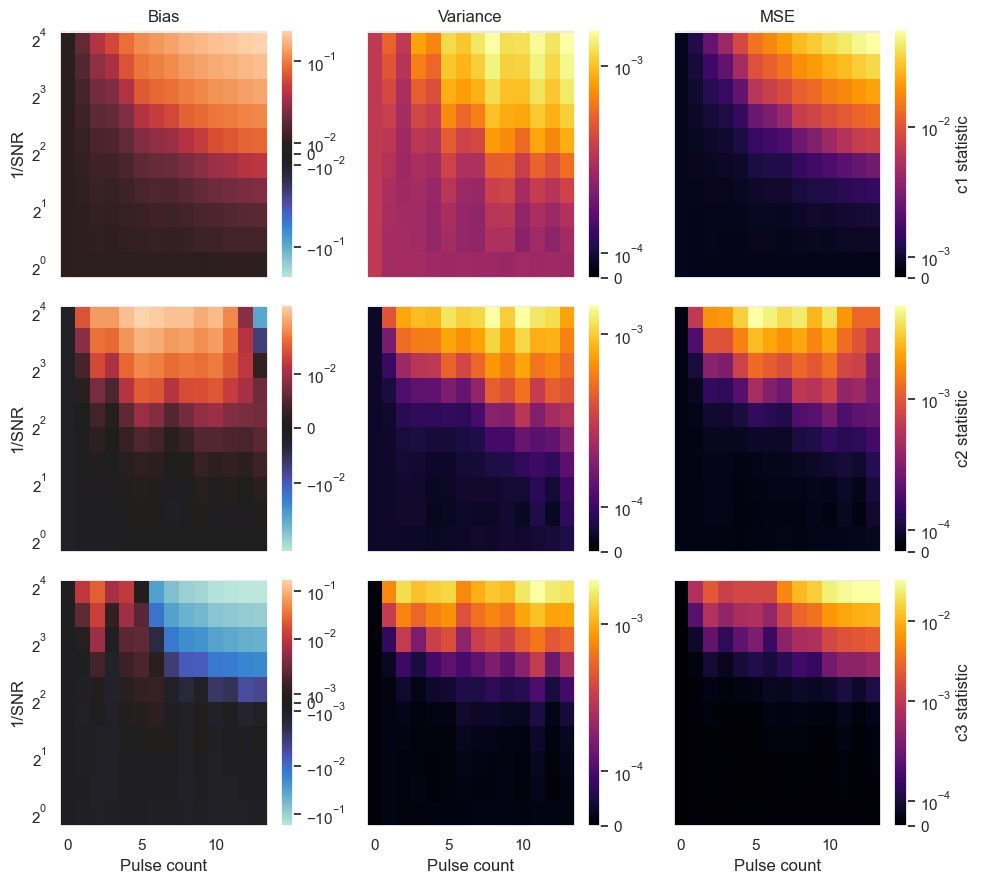

In [40]:
plot_all(df_boot_th)